In [32]:
import numpy as np
import numba
from numba import jit , njit
import numpy as np
import os
import sys
import pandas
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import log2
from sklearn import preprocessing
import sys
import timeit
import datetime
import json
import random
from collections import defaultdict
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
import warnings

warnings.filterwarnings("ignore")

### **Note** that you might need to uncomment some portions of balance and fairness error methods while executing Bank dataset (three valued protected group)

In [33]:
# Global Config Variables --------------------------------------------------------------
A = 5                 # No of attributes
iterations = 1        # Maximum iteration in clustering

option = 'Kmeans'       

In [34]:
# Function to load adult dataset.
def load_adult(data_dir=''):
    data_dir = data_dir
    _path = '../Datasets/adult_p.csv'
    data_path = os.path.join(data_dir, _path)
    df = pandas.read_csv(data_path, sep=',')
    return df

In [35]:
"""
    Takes the data, number of clusters 
    returns centroids, cluster_assignment, heterogeneity, cost_variation
"""
def VanillaKmeans(X, k):
    n_row, n_col = X.shape
    maxiter=100
    
    # randomly choose k data points as initial centroids
    rand_indices = np.random.choice(n_row, size = k)
    centroids = X[rand_indices]
    
    cost_variation=[]
    cnt = 0
    
    for itr in range(maxiter):
        
        # compute distances between each data point and the set of centroids and assign each data point to the closest centroid
        distances_to_centroids = pairwise_distances(X, centroids, metric = 'sqeuclidean', force_all_finite=True)
        cluster_assignment = np.argmin(distances_to_centroids, axis = 1)

        # select all data points that belong to cluster i and compute the mean of these data points (each feature individually)
        new_centroids=[]
        for i  in range(k):
            assign= np.array([X[cluster_assignment == i]])
            med = np.mean(assign[0],axis=0)
            new_centroids.append(med)             
        
        
        # if the updated centroid is still the same, then the algorithm converged
        new_centroids = np.array(new_centroids)
        if np.all(centroids == new_centroids):
            cnt = cnt + 1
            if cnt ==4:
                break
        
        centroids = new_centroids
        
        heterogeneity = 0
        for i in range(k):
            # note that pairwise_distance only accepts 2d-array
            cluster_data = X[cluster_assignment == i]
            distances = pairwise_distances(cluster_data, [centroids[i]], metric = 'euclidean')
            heterogeneity += np.sum(distances ** 2) #sq euclidean 
        cost_variation.append(heterogeneity)
        
    return centroids, cluster_assignment, heterogeneity, cost_variation #(cost with k)

In [36]:
# Funtion to print both in file and console.
def dual_print(f,*args,**kwargs):
    print(*args,**kwargs,file=f)



# Function to load the dataset.
def load_dataset(csv_name):
    df = pd.read_csv(csv_name, header=None)
    return df



# Select K random indices from a dataframe.
def k_random_index(df,K):
    # return k random indexes in range of dataframe
    return random.sample(range(0, len(df)), K)



# Returns the final k means clusters centoids.
def find_k_initial_centroid_Kmeans(df,K,seedValue):
    kmeans=KMeans(n_clusters=int(K),random_state=int(seedValue)).fit(df)
    return kmeans.cluster_centers_



# Return the initial k cluster centroids.
def find_k_initial_centroid(df, K):
    centroids = []
    rnd_idx = random.sample(range(len(df)), K)
    for i in rnd_idx:
        coordinates = df.iloc[i].tolist()
        centroids.append(coordinates)
    return centroids



# Calculate equilidean distance
def calc_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5



# Cacluate sq. equildean between two points having n features.
def calc_distance_a(centroid, point):
    sum_ = 0
    for i in range(0, len(centroid)):
        sum_ = sum_ + (centroid[i]-point[i])**2
    return sum_ 



# Finding distances of between centroids and all the datapoints. (optimised)
@njit(parallel=False)
def find_distances_fast(k_centroids, df):
    dist = np.zeros((len(k_centroids),len(df),A+2),np.float64)
    Kcnt = 0 
    for c in k_centroids:  #K-centroid is of form [ c1=[x1,y1.....z1], c2=[x2,y2....z2].....]
        l = np.zeros((len(df),A+2),np.float64)
        
       # for row in df:
        index = 0 
        for row in df:      
             # row is now x,y,z......type
            # append all coordinates to point
            dis = np.sum((c- row[:A])**2) #calc_distance_a(c, point)
            #Processing the vector for list  
            row_list = np.array([dis])
            #append distance or l norm
            row_list = np.append(row_list,row[:A+1])
            #append all coordinates #append type of this row
            
            l[index] = row_list
            index = index + 1
            #l.append([calc_distance(c[0], c[1], row[0], row[1]), row[0], row[1], row[2]])  # [dist, X, Y,....Z , type]
            # l contains list of type [dist,X,Y.....,Z,type] for each points in metric space
        dist[Kcnt]= l
        Kcnt = Kcnt + 1

    # return dist which contains distances of all points from every centroid
    return dist



# Sorting and valuation.
def sort_and_valuation(dist):
    sorted_val = []
  
    for each_centroid_list in dist:
        
        # sort on basis of type & then dist.
        # Now all whites are towards start and all black are after white as they have additional V added to their valuation
        # Among the whites, the most closest is at start of list as it has more valuation.
        # Similarly sort the black points among them based on distance as did with white
        
        each_centroid_list_sorted = sorted(each_centroid_list, key=lambda x: (x[A+1], x[0]))  # A+1 is index of type , 0 is dist
        sorted_val.append(each_centroid_list_sorted)

    return sorted_val



# Round robin clustering.
def clustering(sorted_valuation, hashmap_points,K):
    n = len(hashmap_points.keys())  # total number of points in metric space
    
    cluster_assign = []
    for i in range(0, K):
        cluster_assign.append([])  # initially all clusters are empty
  
    map_index_cluster = []
    for i in range(0,K+2):
        map_index_cluster.append(0)
        #initially check all sorted evaluation from 0th index 
    
    number_of_point_alloc = 0
    curr_cluster = 0
    
    # until all points are allocated
    while number_of_point_alloc != n:  # As convergence is guaranteed that all points will be allocated to some cluster set
        #print('Number of point alloc : '+str(number_of_point_alloc))
        start_inde = map_index_cluster[curr_cluster % K]
        
        for inde in range(start_inde, len(sorted_valuation[curr_cluster % K])):
            each = sorted_valuation[curr_cluster % K][inde]
            # each is (dist,X,Y,....Z,type)
          
            if hashmap_points[tuple(each[1: -1])] == 0:    # each is (dist, X,Y,....Z, type)
                cluster_assign[curr_cluster].append(each)
                hashmap_points[tuple(each[1: -1])] = 1
                number_of_point_alloc += 1
                map_index_cluster[curr_cluster % K] = inde  #next time start from here as isse prev all allocated
                break

        curr_cluster = (curr_cluster + 1) % K

    return cluster_assign

def calc_total_voilations(k_centroids, cluster_assign, fair_radius_map):
    voilations = 0
    for idx in range(len(k_centroids)):
        for point in cluster_assign[idx]:
            tuple_point = tuple(point[1:-1])
            if calc_distance_a(k_centroids[idx], point[1:-1]) > fair_radius_map[tuple_point]:
                voilations += 1
    return voilations

# Update Kmeans centroid.
def update_centroids(cluster_assign,K):

    new_centroids = []
    
    for k in range(0, K):
        
        sum_a = []
        for i in range(0, A):
            sum_a.append(0)
            
        for each in cluster_assign[k]:
            sum_a = [sum(x) for x in zip(sum_a, each[1:-1])] #each is (dist,X,Y,.....Z,type)
            
        new_coordinates = []
        
        for a in range(0, A):
            new_coordinates.append(sum_a[a] / len(cluster_assign[k]))
        new_centroids.append(new_coordinates)
        
        k=k+1
        
    return new_centroids

def calc_fair_radius(point, df, k):
    distances = []
    for index, row in df.iterrows():
        curr_point = []
        for idx in range(len(row)-1):
            curr_point.append(row[idx])
        distances.append(calc_distance_a(point, curr_point)** 0.5)
    sorted_distances = sorted(distances)
    return sorted_distances[int((len(df)-1)/k)]

def optimise_voilation(k_centroids, cluster_assign, fair_radius_map):
    reduce_voilation = 0
    for idx in range(len(k_centroids)):
        for point in cluster_assign[idx]:
            tuple_point = tuple(point[1:-1])
            # means we get the unfair and unvisited point.
            if (calc_distance_a(k_centroids[idx], point[1:-1]) > fair_radius_map[tuple_point]) and (point[-1] != 10):
                for idx2 in range(len(k_centroids)):
                    if point[-1] == 10:
                        break
                    if idx2 == idx:
                        continue
                    if (calc_distance_a(k_centroids[idx2], point[1:-1]) > fair_radius_map[tuple_point]):
                            continue
                    for point2 in cluster_assign[idx2]:
                        tuple_point2 = tuple(point2[1:-1])
                        # point is already visited
                        if point2[-1] == 10:
                            continue
                        if (calc_distance_a(k_centroids[idx2], point2[1:-1]) > fair_radius_map[tuple_point2]) and  (calc_distance_a(k_centroids[idx], point2[1:-1]) <= fair_radius_map[tuple_point2] and (point[-1] == point2[-1])):
                            reduce_voilation += 2 
                            point2[-1] = 10
                            point[-1] = 10
                            break;
                    # point already visited
                    if point[-1] != 10:
                        for point2 in cluster_assign[idx2]:
                            tuple_point2 = tuple(point2[1:-1])
                            if point2[-1] == 10:
                                continue
                            if (calc_distance_a(k_centroids[idx], point2[1:-1]) <= fair_radius_map[tuple_point2] and (point[-1] == point2[-1])):
                                reduce_voilation += 1
                                point2[-1] = 10
                                point[-1] = 10
                                break;
    print(reduce_voilation)
    return reduce_voilation
                            
# Function to calculate clustering objective.
def calc_clustering_objective(k_centroid, cluster_assign,K):
    
    cost = 0

    for k in range(0, K):
        for each in cluster_assign[k]:  #each is (dist, X,Y,....,Z,type)
            dd = calc_distance_a(k_centroid[k], each[1:-1])
            cost = cost + (dd)
            
    return cost



# Function to calculate the fairness error for 'adult' dataset.
def calc_fairness_error_adult(df, cluster_assign, K):
    
    U = []  # Distribution of each type in original target dataset for each J = 0 , 1....
    P_k_sum_over_j = []  # distribution in kth cluster  sum_k( sum_j(   Uj * j wale/total_in_cluster ) )

    f_error = 0
    cnt_j_0 = 0
    cnt_j_1 = 0
    cnt = 0
    
    for index, row in df.iterrows():
        if row.iloc[-1] == 1:
            cnt_j_1 += 1
        elif row.iloc[-1] == 0:
            cnt_j_0 += 1
        cnt += 1

    U.append(cnt_j_0 / cnt)
    U.append(cnt_j_1 / cnt)

    for k in range(0, K):  # for each cluster

        for j in range(0, len(U)):   #for each demographic group

            cnt_j_cluster = 0
            cnt_total = 0

            for each in cluster_assign[k]:
                if int(each[-1]) == j:    #each is (dist,X, Y.....,Z,type)
                    cnt_j_cluster += 1
                cnt_total += 1
                
            if cnt_j_cluster !=0 and cnt_total != 0:
                P_k_sum_over_j.append(-U[j] * np.log((cnt_j_cluster / cnt_total)/U[j]))
            else:
                P_k_sum_over_j.append(0)  #log(0)=0 considered

    for each in P_k_sum_over_j:
        f_error += each

    return f_error



# Function to calculate balance for 'adult' dataset.
def calc_balance_adult(cluster_assign, K):
    S_k = []  
    balance = 0  

    for k in range(0, K):
        
        cnt_j_0 = 0
        cnt_j_1 = 0
        cnt = 0
        
        for each in cluster_assign[k]:
            if int(each[-1]) == 1:
                cnt_j_1 += 1
            elif int(each[-1]) == 0:
                cnt_j_0 += 1
            cnt += 1

        if cnt_j_0 != 0 and cnt_j_1 != 0 :
            S_k.append(min([cnt_j_0 / cnt_j_1, cnt_j_1 / cnt_j_0 ]))
        elif cnt_j_0 == 0 or cnt_j_1 ==0 :
            S_k.append(0)
        
    balance = min(S_k)
    return balance

In [37]:
# Loading the adult data ---------------------------------------------------------------------------------

df=load_adult()
df= df.round(decimals=5)
typ = df['type'].values
zero_count = np.count_nonzero(typ == 0)
one_count = np.count_nonzero(typ == 1)
print("Zero's = ", zero_count)
print("One's = ", one_count)
print("Zero/Total = ", zero_count / (zero_count + one_count))
print("One/Total = ", one_count / (zero_count + one_count))  
df_dropped = df.drop(columns=['type'])

Zero's =  21790
One's =  10771
Zero/Total =  0.6692054912318418
One/Total =  0.33079450876815825


In [38]:
list_fair_K=[]
list_obj_K =[]       
list_balance_K=[]
list_obj_K_std =[]
list_fair_K_std=[]
list_balance_K_std=[]
list_voilation_K=[]
list_voilation_K_std=[]
list_optimised_voilation_K=[]
list_optimised_voilation_K_std=[]
# Try catch 
try:
    os.makedirs('Adult_kmeans_center')
    print("Directory 'Adult_kmeans_center' created successfully!")
except OSError as e:
    print("Error creating directory:", e)


for kk in [2, 5, 10, 15, 20, 30, 40]:
    K = kk

    # For cluster size = K
    print("K == "+str(K)+"  ")
    
    cost_variation_ck_collec = []
    cost_variation_collec = []
    
    list_fair_run = []
    list_obj_run = []       
    list_balance_run = []
    list_voilation_run = []
    list_optimised_voilation_run = []

    fair_radius = pd.read_csv(f"fair_radius_k_{kk}.csv")
    fair_radius_df = pd.concat([df, fair_radius], axis=1)
    row_to_fair_radius_map = {}

    for index, row in fair_radius_df.iterrows():
        point = []
        for idx in range(len(row)-2):
            point.append(row[idx])
        row_to_fair_radius_map.update({tuple(point): row[-1]})

    seeds = [0, 100, 200]
    
    # For 3 independent runs.
    for run in range(0, len(seeds)):

        np.random.seed(seeds[run])
        random.seed(seeds[run])
    
        list_fair_iter=[]
        list_obj_iter =[]
        list_balance_iter=[]

        # Step2 : Find initial K random centroids using k_random_index(df) & find_k_initial_centroid(df)
        if option=='Kmeans':
            k_centroid,_,_,cost_variation= VanillaKmeans(df_dropped.values, kk)#VanillaKmeans()find_k_initial_centroid_Kmeans(dfDropped,kk,seeds[run])#find_k_initial_centroid(df,kk)
        else:
            k_centroid,_,_,cost_variation= VanillaKmedian(df_dropped.values, kk)#VanillaKmeans()find_k_initial_centroid_Kmeans(dfDropped,kk,seeds[run])#find_k_initial_centroid(df,kk)
        
        cost_variation_ck = []
        
        for eac in cost_variation:
            cost_variation_ck.append(eac)
        
       
        prev_assignment =[]
        cluster_assignment = []

        for i in range(0, K):
            cluster_assignment.append([])  # initially all clusters are empty

        sum_time = 0
        curr_itr = 0
        prev_objective_cost = -1
        objective_cost = 0
        
        # Step3 : Find distances from the centroids using find_distances() with list of [ [x1,y1,z1..] , [x2,y2,z2..]....] centroids format list
        while curr_itr < iterations:# and prev_objective_cost != objective_cost:
         
            df1 = df.values
            k_centroids1= np.array(k_centroid)

            dist = find_distances_fast(k_centroids1, df1)
            valuation = sort_and_valuation(dist)
           
            #Step5 : Perform clustering using valuation matrix & hashmap of all points in metric
            hash_map = {}
            for index, row in df.iterrows():
                temp = tuple(row[:-1])
                hash_map.update({tuple(row[:-1]): 0})   #dict is of form { (x,y): 0 , ....}
        
            prev_assignment = cluster_assignment
            cluster_assignment = clustering(valuation, hash_map, K)
            
            balance = calc_balance_adult(cluster_assignment, K)
            f_error = calc_fairness_error_adult(df, cluster_assignment, K)
            clustering_cost = calc_clustering_objective(k_centroid,cluster_assignment,K)
            
            if curr_itr!=0:
                 prev_objective_cost = objective_cost
                
            objective_cost = np.round(clustering_cost,3)
            
            cost_variation_ck.append(objective_cost)
            

            list_balance_iter.append(str(balance))
            list_obj_iter.append(str(objective_cost))
            list_fair_iter.append(str(f_error))

        

            #Step7 : Find new centroids using mean of all points in current assignment
            if option=='Kmeans':
                k_centroid_temp = update_centroids(cluster_assignment,K)
            else:
                k_centroid_temp = update_centroids_median(cluster_assignment,K)
            
            clustering_cost_temp = calc_clustering_objective(k_centroid_temp,cluster_assignment,K)
            cost_variation.append(np.round(clustering_cost_temp,3))
            curr_itr += 1

        #Step 10 : Find balance , fairness error , and clustering objective or cost

        balance_converged = calc_balance_adult(cluster_assignment,K)
        f_error_converged = calc_fairness_error_adult(df, cluster_assignment,K)
        clustering_cost_converged = calc_clustering_objective(k_centroid, cluster_assignment,K)
        voilation_converged = calc_total_voilations(k_centroid, cluster_assignment, row_to_fair_radius_map)
        optimised_voilation_converged = optimise_voilation(k_centroid, cluster_assignment, row_to_fair_radius_map)
        
        cost_variation_collec.append(cost_variation)        
        run  = run + 1
        list_obj_run.append(clustering_cost_converged)
        list_fair_run.append(f_error_converged)
        list_balance_run.append(balance_converged)
        list_voilation_run.append(voilation_converged)
        list_optimised_voilation_run.append(voilation_converged - optimised_voilation_converged)
        
    list_obj_K.append(np.mean(np.array(list_obj_run)))
    list_fair_K.append(np.mean(np.array(list_fair_run)))
    list_balance_K.append(np.mean(np.array(list_balance_run)))
    list_voilation_K.append(np.mean(np.array(list_voilation_run)))
    list_optimised_voilation_K.append(np.mean(np.array(list_optimised_voilation_run)))
    list_obj_K_std.append(np.std(np.array(list_obj_run)))
    list_fair_K_std.append(np.std(np.array(list_fair_run)))
    list_balance_K_std.append(np.std(np.array(list_balance_run)))
    list_voilation_K_std.append(np.std(np.array(list_voilation_run)))
    list_optimised_voilation_K_std.append(np.std(np.array(list_optimised_voilation_run)))
    
    
print('Mean Cost variation over K ',list_obj_K)
print('Mean Fairness Error variation over K ',list_fair_K)
print('Mean Balance variation over K ',list_balance_K)
print('Mean Voilation variation over K ',list_voilation_K)
print('Mean Optimised Voilation variation over K ',list_optimised_voilation_K)
print('Std Cost variation over K ',list_obj_K_std)
print('Std F.Error variation over K ',list_fair_K_std)
print('Std Balance variation over K ',list_balance_K_std)
print('Std Voilation variation over K ',list_voilation_K_std)
print('Std Optimised Voilation variation over K ',list_optimised_voilation_K_std)

Error creating directory: [Errno 17] File exists: 'Adult_kmeans_center'
K == 2  
10
10
10
K == 5  
737
724
748
K == 10  
841
857
561
K == 15  
1106
864
555
K == 20  
1070
680
741
K == 30  
736
880
594
K == 40  
905
913
1054
Mean Cost variation over K  [24915.17840172499, 15783.621051958995, 11806.954181040717, 10132.260969829782, 8917.174959272488, 7517.264330715443, 7108.406221307603]
Mean Fairness Error variation over K  [3.2434077390586583e-06, 8.144449203607114e-06, 1.640868668946482e-05, 2.5440986940645366e-05, 3.329669263364438e-05, 5.4981463993622774e-05, 6.851199767323856e-05]
Mean Balance variation over K  [0.49615776317007687, 0.4959500115713955, 0.4956038870893105, 0.4954892435808466, 0.49491211840888066, 0.49514563106796117, 0.49353049907578556]
Mean Voilation variation over K  [10.0, 2076.6666666666665, 2716.0, 2978.3333333333335, 3043.6666666666665, 2846.3333333333335, 3284.3333333333335]
Mean Optimised Voilation variation over K  [0.0, 1340.3333333333333, 1963.0, 2136.66

ValueError: 'After optimisation' is not a valid value for color

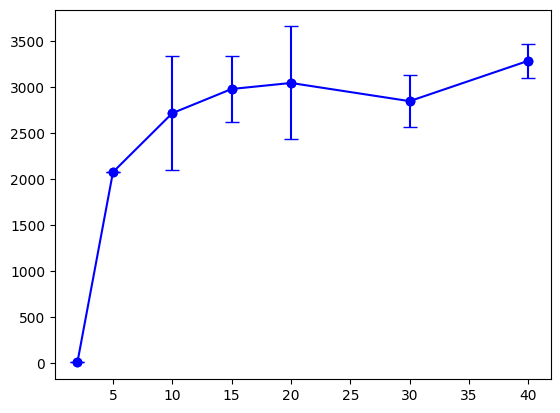

In [43]:
x = [2, 5, 10, 15, 20, 30, 40]
y = list_voilation_K
std = list_voilation_K_std
y1 = list_optimised_voilation_K
std1 = list_optimised_voilation_K_std
plt.errorbar(x, y, yerr=std, fmt='o', capsize=5, color='b')  
plt.plot(x, y, linestyle='-', marker='o', color='b', label ='Before optimisation')
plt.errorbar(x, y1, yerr=std1, fmt='o', capsize=5, color='g',)  
plt.plot(x, y1, linestyle='-', marker='o', color='g', label = 'After optimisation')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Number of Voilations')
plt.title(' Voilation vs K')
plt.show()

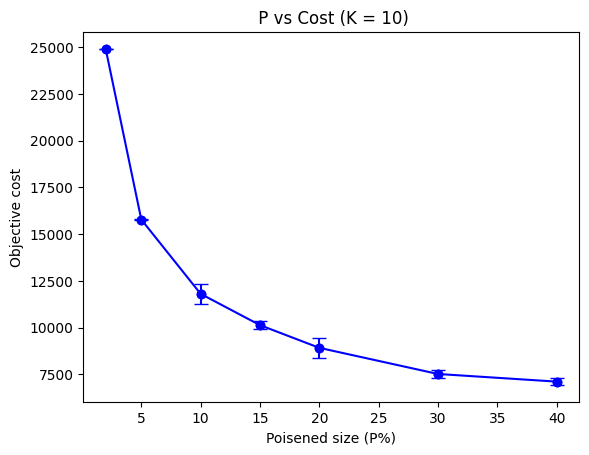

In [40]:
x = [2, 5, 10, 15, 20, 30, 40]
y = list_obj_K
std = list_obj_K_std
plt.errorbar(x, y, yerr=std, fmt='o', capsize=5, color='b')  
plt.plot(x, y, linestyle='-', marker='o', color='b')
plt.xlabel('Poisened size (P%)')
plt.ylabel('Objective cost')
plt.title(' P vs Cost (K = 10)')
plt.show()

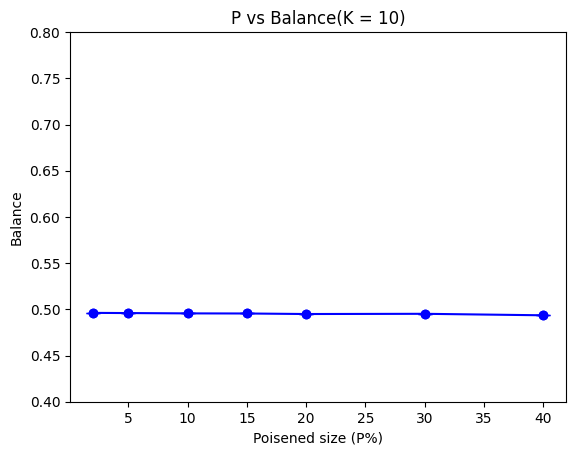

In [41]:
x = [2, 5, 10, 15, 20, 30, 40]
y = list_balance_K
std = list_balance_K_std
plt.errorbar(x, y, yerr=std, fmt='o', capsize=5, color='b')  
plt.plot(x, y, linestyle='-', marker='o', color='b')
plt.xlabel('Poisened size (P%)')
plt.ylabel('Balance')
plt.title('P vs Balance(K = 10)')
plt.ylim(0.4,0.8)
plt.show()

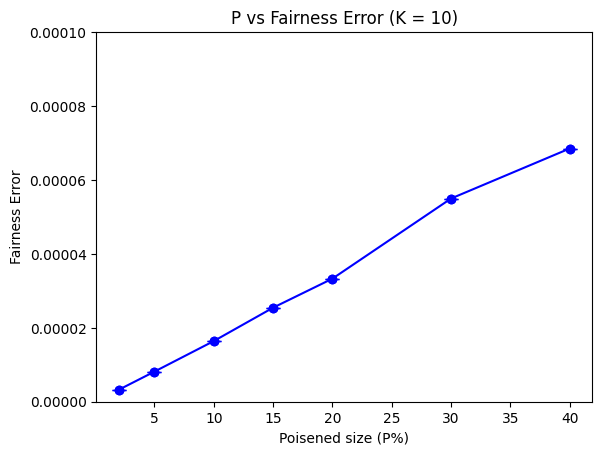

In [42]:
x = [2, 5, 10, 15, 20, 30, 40]
y = list_fair_K
std = list_fair_K_std
plt.errorbar(x, y, yerr=std, fmt='o', capsize=5, color='b')  
plt.plot(x, y, linestyle='-', marker='o', color='b') 
plt.xlabel('Poisened size (P%)')
plt.ylabel('Fairness Error')
plt.title('P vs Fairness Error (K = 10)')
plt.ylim(0,0.0001)
plt.show()